# Transfer line quadrupole tuning

The beamline consists of 21 quadrupoles whose strength will be varied in order to fulfill the following optimization targets:

* Beam spot size @ target position: $\sigma_x \leq 500\,\mu m, \sigma_y \leq 500\,\mu m$
* Beam spot size @ beam dump position: $\sigma_x \leq 12\,mm, \sigma_y \leq 12\,mm$
* Fractional beam loss along beamline less than 1%

Let's start with importing everything that we are going to need throughout the optimization process:

In [1]:
from collections import deque
import itertools as it
import logging
import math
import os
from pprint import pprint
import statistics

import numpy as np
import pandas as pd
import torch

from dipas.build import from_file, create_script, track_script
from dipas.elements import configure, Quadrupole
from dipas.madx import run_script

In the following we define the optimization targets as above:

In [2]:
optimization_targets = dict(
    target_rms_x = 500e-6,  # Beam spot size at target.
    target_rms_y = 500e-6,
    dump_rms_x = 12e-3,     # Beam spot size at beam dump.
    dump_rms_y = 12e-3,
    loss = 0.01             # Fractional loss along beamline.
)

Using the `build.from_file` function we can load the example lattice from a MADX script file:

In [3]:
configure(transfer_map_order=1)  # Using linear optics to save memory.
lattice = from_file('example.seq')
print(lattice)

Segment(elements=[Drift(l=tensor(3.9057), label='pad_drift_0'),
 VKicker(l=tensor(0.), hkick=tensor(0.), vkick=tensor(0.), kick=tensor(0.), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte1ky1'),
 Drift(l=tensor(0.8420), label='pad_drift_1'),
 Quadrupole(l=tensor(0.6660), k1=Parameter containing: tensor(1.5015e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte1qd11'),
 Drift(l=tensor(0.3370), label='pad_drift_2'),
 Monitor(l=tensor(0.), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte1dg1'),
 Monitor(l=tensor(0.), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte1df1'),
 Drift(l=tensor(0.6470), label='pad_drift_4'),
 Quadrupole(l=tensor(0.6660), k1=Parameter containing: tensor(-1.5015e-06, requires_grad=True), aperture=Aper

We are only interested in the part of the beamline up to the beam dump position, so we select the corresponding segment:

In [4]:
lattice = lattice[:'dump']
print('Last lattice element:', lattice.elements[-1])

Last lattice element: Monitor(l=tensor(0.), label='dump')


In a next step we would declare the parameters of the optimization process, i.e. the quadrupoles' gradient strengths. However this step has been done already in the corresponding MADX script. The MADX parser supports special comments of the form `// [flow] variable` to indicate optimization parameters. These comments work for variable definitions as well as attribute updates (e.g. `some_element->k1 = 0.0;`). Let's view the corresponding section of the MADX script file:

In [5]:
with open('example.seq') as fh:
    print(''.join(fh.readlines()[:30]))

beam, particle=ion, charge=6, energy=28.5779291448, mass=11.1779291448;

k1l_GTE1QD11 =  1e-6;  // [flow] variable
k1l_GTE1QD12 = -1e-6;  // [flow] variable

k1l_GTE2QT11 =  1e-6;  // [flow] variable
k1l_GTE2QT12 = -1e-6;  // [flow] variable
k1l_GTE2QT13 =  1e-6;  // [flow] variable

k1l_GTH1QD11 =  1e-6;  // [flow] variable
k1l_GTH1QD12 = -1e-6;  // [flow] variable

k1l_GTH2QD11 =  1e-6;  // [flow] variable
k1l_GTH2QD12 = -1e-6;  // [flow] variable
k1l_GTH2QD21 = -1e-6;  // [flow] variable
k1l_GTH2QD22 =  1e-6;  // [flow] variable

k1l_GHADQD11 = -1e-6;  // [flow] variable
k1l_GHADQD12 =  1e-6;  // [flow] variable
k1l_GHADQD21 = -1e-6;  // [flow] variable
k1l_GHADQD22 =  1e-6;  // [flow] variable

k1l_GHADQD31 = -1e-6;  // [flow] variable
k1l_GHADQD32 =  1e-6;  // [flow] variable
k1l_GHADQD41 =  1e-6;  // [flow] variable
k1l_GHADQD42 = -1e-6;  // [flow] variable

k1l_GHADQT51 =  1e-6;  // [flow] variable
k1l_GHADQT52 = -1e-6;  // [flow] variable




We can confirm that the parsed lattice contains the corresponding parameters already:

In [6]:
for quad in lattice[Quadrupole]:
    print(f'{quad.label}: {quad.k1!r}')
print('Number of parameters:', len(list(lattice.parameters())))

gte1qd11: Parameter containing:
tensor(1.5015e-06, requires_grad=True)
gte1qd12: Parameter containing:
tensor(-1.5015e-06, requires_grad=True)
gte2qt11: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gte2qt12: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gte2qt13: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gth1qd11: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gth1qd12: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gth2qd11: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gth2qd12: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gth2qd21: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gth2qd22: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
ghadqd11: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
ghadqd12: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
ghadqd21: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)

If the optimization parameters were not already declared we could also do it manually using the following `for` loop:

In [7]:
# for quad in lattice[Quadrupole]:
#     quad.k1 = torch.nn.Parameter(quad.k1)
#     quad.update_transfer_map()  # Need to call this method in order for the change to become effective.

In a next step we select the 21 quadrupoles and define some additional properties such as valid boundaries for their k1-values. An important aspect to note here is that k1-values which are marked as optimization parameters must never be zero. This is because internally the polarity of the magnet is derived from the sign of the k1-value (positive sign means horizontally focusing). For that reason we define a small epsilon-boundary instead (any value other than zero would do, no matter how small). Also note that this restriction only applies to k1-values that are `Parameters`. For non-parameters, if the k1-value is zero, the Quadrupole acts as a Drift space.

In [8]:
quadrupoles = lattice[Quadrupole]
pprint(quadrupoles)
print()

QPL_limit = 11.1 / 14.62
QPK_limit = 6.88 / 14.62
QPK_magnets = {'gte1qd11', 'gte1qd12', 'ghadqd31', 'ghadqd32', 'ghadqd41', 'ghadqd42'}
polarity = {  # +1.0 means horizontally focusing.
    'gte1qd11':  1.0,
    'gte1qd12': -1.0,

    'gte2qt11':  1.0,
    'gte2qt12': -1.0,
    'gte2qt13':  1.0,

    'gth1qd11':  1.0,
    'gth1qd12': -1.0,

    'gth2qd11':  1.0,
    'gth2qd12': -1.0,
    'gth2qd21': -1.0,
    'gth2qd22':  1.0,

    'ghadqd11': -1.0,
    'ghadqd12':  1.0,
    'ghadqd21': -1.0,
    'ghadqd22':  1.0,

    'ghadqd31': -1.0,
    'ghadqd32':  1.0,
    'ghadqd41':  1.0,
    'ghadqd42': -1.0,

    'ghadqt51':  1.0,
    'ghadqt52': -1.0,
}
k1_bounds = {
    q.label: sorted([  # Lower bound must come first.
        polarity[q.label] * 1e-6,  # Variable strength quadrupoles must not be zero to retain their polarity.
        polarity[q.label] * (QPK_limit if q.label in QPK_magnets else QPL_limit)
    ]) for q in quadrupoles
}
pprint(k1_bounds)

[Quadrupole(l=tensor(0.6660), k1=Parameter containing: tensor(1.5015e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte1qd11'),
 Quadrupole(l=tensor(0.6660), k1=Parameter containing: tensor(-1.5015e-06, requires_grad=True), aperture=ApertureCircle(aperture=0.06, offset=tensor([0., 0.]), padding=0.0), label='gte1qd12'),
 Quadrupole(l=tensor(1.), k1=Parameter containing: tensor(1.0000e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte2qt11'),
 Quadrupole(l=tensor(1.), k1=Parameter containing: tensor(-1.0000e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte2qt12'),
 Quadrupole(l=tensor(1.), k1=Parameter containing: tensor(1.0000e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]),

The initial particle distribution at the entrance of the beamline is stored in a CSV file (5,000 particles):

In [9]:
particles = pd.read_csv('particles.csv', index_col=0)
particles = torch.from_numpy(particles.values.T)
print('Particles:', particles.shape)

Particles: torch.Size([6, 5000])


Now let's run a tracking forward pass through the lattice in order to verify everything's set up correctly:

In [10]:
x, history, loss = lattice.linear(particles, observe=['target', 'dump'], recloss='sum')
print(x.shape)
print({k: v.shape for k, v in history.items()})
print(loss)

torch.Size([6, 1878])
{'target': torch.Size([6, 1878]), 'dump': torch.Size([6, 1878])}
tensor(1073.9377, grad_fn=<AddBackward0>)


Here we can see that out of the initial 5,000 particles only 1,878 make it to the end of the beamline. The remaining 3,122 are lost at the various elements in between and this is reflected in the loss value `loss`. This value is the sum over all elements and for each particle and element it indicates by how much the particle's spatial coordinates exceeded the element's aperture (so it is not directly related to the fraction of particles lost; this value can be computed from the shape of the tensors). If we wanted to know where exactly the particles are lost, we would need to specify `recloss=True` (or more generally `recloss=identifier`, see the documentation of `elements.Segment` for more details). We can also observe that the `loss` value is differentiable, as indicated by the `grad_fn` attribute.

Finally we setup the optimizer that computes the updates for the k1-values during the optimization process. For this example we use the `Adam` optimizer:

In [11]:
optimizer = torch.optim.Adam(lattice.parameters(), lr=0.001)

Now we're ready to start the optimization:

In [12]:
cost_history = []

for epoch in it.count(1):
    def closure():
        optimizer.zero_grad()
        
        __, history, loss = lattice.linear(particles, observe=['target', 'dump'],
                                           recloss='sum',      # Sum the loss per element and per particle.
                                           exact_drift=False)  # Linear drifts speed up the computation.
        particles_lost = 1.0 - history['dump'].shape[1] / particles.shape[1]
        if particles_lost > optimization_targets['loss']:
            cost = (loss / particles.shape[1]) / optimization_targets['loss']  # Average loss per particle / target loss.
        else:
            cost = 0.  # Target fractional loss was reached, no need to optimize for that (at the current iteration).

        log_dict = dict(epoch=epoch, particles_lost=f'{particles_lost:.2f}')

        for place in ('target', 'dump'):
            # Only compare spot sizes to targeted ones if no more than 50% of the particles were lost.
            if history[place].shape[1] > particles.shape[1] // 2:
                x, y = history[place][[0, 2]]
                rms_x = x.std()
                rms_y = y.std()
                cost = (cost + torch.nn.functional.relu(rms_x / optimization_targets[f'{place}_rms_x'] - 1.0)
                        + torch.nn.functional.relu(rms_y / optimization_targets[f'{place}_rms_y'] - 1.0))
                log_dict.update({f'{place}_rms_x': f'{rms_x.data:.6f}', f'{place}_rms_y': f'{rms_y:.6f}'})
            else:
                log_dict.update({f'{place}_rms_x': 'n.a.', f'{place}_rms_y': 'n.a.'})
                
        cost_history.append(cost.data.clone())
        log_dict['cost_to_optimize'] = cost.data.clone()
        print(log_dict)
        cost.backward(retain_graph=True)  # Transfer maps are reused at every iteration so we need to retain the memory buffers.
        return cost
    
    optimizer.step(closure)
    
    if cost_history[-1] == 0:
        break

    with torch.no_grad():
        for q in quadrupoles:
            q.k1.data.clamp_(*k1_bounds[q.label])  # Squeeze k1-values back into bounds if necessary.
            
    for q in quadrupoles:
        q.update_transfer_map()

{'epoch': 1, 'particles_lost': '0.62', 'target_rms_x': 'n.a.', 'target_rms_y': 'n.a.', 'dump_rms_x': 'n.a.', 'dump_rms_y': 'n.a.', 'cost_to_optimize': tensor(21.4532)}
{'epoch': 2, 'particles_lost': '0.62', 'target_rms_x': 'n.a.', 'target_rms_y': 'n.a.', 'dump_rms_x': 'n.a.', 'dump_rms_y': 'n.a.', 'cost_to_optimize': tensor(20.3271)}
{'epoch': 3, 'particles_lost': '0.61', 'target_rms_x': 'n.a.', 'target_rms_y': 'n.a.', 'dump_rms_x': 'n.a.', 'dump_rms_y': 'n.a.', 'cost_to_optimize': tensor(19.2047)}
{'epoch': 4, 'particles_lost': '0.61', 'target_rms_x': 'n.a.', 'target_rms_y': 'n.a.', 'dump_rms_x': 'n.a.', 'dump_rms_y': 'n.a.', 'cost_to_optimize': tensor(18.3123)}
{'epoch': 5, 'particles_lost': '0.60', 'target_rms_x': 'n.a.', 'target_rms_y': 'n.a.', 'dump_rms_x': 'n.a.', 'dump_rms_y': 'n.a.', 'cost_to_optimize': tensor(16.9551)}
{'epoch': 6, 'particles_lost': '0.59', 'target_rms_x': 'n.a.', 'target_rms_y': 'n.a.', 'dump_rms_x': 'n.a.', 'dump_rms_y': 'n.a.', 'cost_to_optimize': tensor(15

{'epoch': 47, 'particles_lost': '0.19', 'target_rms_x': '0.003650', 'target_rms_y': '0.002928', 'dump_rms_x': '0.010385', 'dump_rms_y': '0.004122', 'cost_to_optimize': tensor(19.4862)}
{'epoch': 48, 'particles_lost': '0.19', 'target_rms_x': '0.003682', 'target_rms_y': '0.003044', 'dump_rms_x': '0.010985', 'dump_rms_y': '0.004680', 'cost_to_optimize': tensor(19.4799)}
{'epoch': 49, 'particles_lost': '0.18', 'target_rms_x': '0.003718', 'target_rms_y': '0.003154', 'dump_rms_x': '0.011531', 'dump_rms_y': '0.004802', 'cost_to_optimize': tensor(19.5147)}
{'epoch': 50, 'particles_lost': '0.18', 'target_rms_x': '0.003741', 'target_rms_y': '0.003252', 'dump_rms_x': '0.011960', 'dump_rms_y': '0.004512', 'cost_to_optimize': tensor(19.4775)}
{'epoch': 51, 'particles_lost': '0.18', 'target_rms_x': '0.003665', 'target_rms_y': '0.003356', 'dump_rms_x': '0.012293', 'dump_rms_y': '0.005123', 'cost_to_optimize': tensor(19.2216)}
{'epoch': 52, 'particles_lost': '0.17', 'target_rms_x': '0.003574', 'target

{'epoch': 92, 'particles_lost': '0.11', 'target_rms_x': '0.003071', 'target_rms_y': '0.003297', 'dump_rms_x': '0.010342', 'dump_rms_y': '0.004834', 'cost_to_optimize': tensor(13.6733)}
{'epoch': 93, 'particles_lost': '0.11', 'target_rms_x': '0.003077', 'target_rms_y': '0.003293', 'dump_rms_x': '0.010344', 'dump_rms_y': '0.004819', 'cost_to_optimize': tensor(13.5777)}
{'epoch': 94, 'particles_lost': '0.11', 'target_rms_x': '0.003083', 'target_rms_y': '0.003290', 'dump_rms_x': '0.010334', 'dump_rms_y': '0.004794', 'cost_to_optimize': tensor(13.4889)}
{'epoch': 95, 'particles_lost': '0.10', 'target_rms_x': '0.003088', 'target_rms_y': '0.003284', 'dump_rms_x': '0.010276', 'dump_rms_y': '0.004826', 'cost_to_optimize': tensor(13.3655)}
{'epoch': 96, 'particles_lost': '0.10', 'target_rms_x': '0.003095', 'target_rms_y': '0.003276', 'dump_rms_x': '0.010208', 'dump_rms_y': '0.004772', 'cost_to_optimize': tensor(13.2750)}
{'epoch': 97, 'particles_lost': '0.10', 'target_rms_x': '0.003102', 'target

{'epoch': 137, 'particles_lost': '0.06', 'target_rms_x': '0.003257', 'target_rms_y': '0.003083', 'dump_rms_x': '0.008661', 'dump_rms_y': '0.004718', 'cost_to_optimize': tensor(11.4809)}
{'epoch': 138, 'particles_lost': '0.06', 'target_rms_x': '0.003254', 'target_rms_y': '0.003084', 'dump_rms_x': '0.008662', 'dump_rms_y': '0.004428', 'cost_to_optimize': tensor(11.4656)}
{'epoch': 139, 'particles_lost': '0.06', 'target_rms_x': '0.003249', 'target_rms_y': '0.003095', 'dump_rms_x': '0.008685', 'dump_rms_y': '0.004753', 'cost_to_optimize': tensor(11.4553)}
{'epoch': 140, 'particles_lost': '0.06', 'target_rms_x': '0.003247', 'target_rms_y': '0.003093', 'dump_rms_x': '0.008685', 'dump_rms_y': '0.004433', 'cost_to_optimize': tensor(11.4465)}
{'epoch': 141, 'particles_lost': '0.06', 'target_rms_x': '0.003239', 'target_rms_y': '0.003104', 'dump_rms_x': '0.008709', 'dump_rms_y': '0.004765', 'cost_to_optimize': tensor(11.4338)}
{'epoch': 142, 'particles_lost': '0.06', 'target_rms_x': '0.003237', '

{'epoch': 182, 'particles_lost': '0.04', 'target_rms_x': '0.003167', 'target_rms_y': '0.003048', 'dump_rms_x': '0.008307', 'dump_rms_y': '0.004570', 'cost_to_optimize': tensor(10.8821)}
{'epoch': 183, 'particles_lost': '0.04', 'target_rms_x': '0.003165', 'target_rms_y': '0.003050', 'dump_rms_x': '0.008302', 'dump_rms_y': '0.004704', 'cost_to_optimize': tensor(10.8742)}
{'epoch': 184, 'particles_lost': '0.04', 'target_rms_x': '0.003164', 'target_rms_y': '0.003045', 'dump_rms_x': '0.008281', 'dump_rms_y': '0.004541', 'cost_to_optimize': tensor(10.8617)}
{'epoch': 185, 'particles_lost': '0.04', 'target_rms_x': '0.003161', 'target_rms_y': '0.003048', 'dump_rms_x': '0.008282', 'dump_rms_y': '0.004734', 'cost_to_optimize': tensor(10.8584)}
{'epoch': 186, 'particles_lost': '0.04', 'target_rms_x': '0.003160', 'target_rms_y': '0.003043', 'dump_rms_x': '0.008258', 'dump_rms_y': '0.004519', 'cost_to_optimize': tensor(10.8453)}
{'epoch': 187, 'particles_lost': '0.04', 'target_rms_x': '0.003155', '

{'epoch': 227, 'particles_lost': '0.03', 'target_rms_x': '0.003029', 'target_rms_y': '0.002995', 'dump_rms_x': '0.008072', 'dump_rms_y': '0.004649', 'cost_to_optimize': tensor(10.4448)}
{'epoch': 228, 'particles_lost': '0.03', 'target_rms_x': '0.003024', 'target_rms_y': '0.002996', 'dump_rms_x': '0.008082', 'dump_rms_y': '0.004708', 'cost_to_optimize': tensor(10.4307)}
{'epoch': 229, 'particles_lost': '0.03', 'target_rms_x': '0.003020', 'target_rms_y': '0.002994', 'dump_rms_x': '0.008081', 'dump_rms_y': '0.004683', 'cost_to_optimize': tensor(10.4168)}
{'epoch': 230, 'particles_lost': '0.03', 'target_rms_x': '0.003015', 'target_rms_y': '0.002993', 'dump_rms_x': '0.008082', 'dump_rms_y': '0.004680', 'cost_to_optimize': tensor(10.4048)}
{'epoch': 231, 'particles_lost': '0.03', 'target_rms_x': '0.003010', 'target_rms_y': '0.002993', 'dump_rms_x': '0.008087', 'dump_rms_y': '0.004715', 'cost_to_optimize': tensor(10.3909)}
{'epoch': 232, 'particles_lost': '0.03', 'target_rms_x': '0.003007', '

{'epoch': 272, 'particles_lost': '0.03', 'target_rms_x': '0.002829', 'target_rms_y': '0.002902', 'dump_rms_x': '0.008006', 'dump_rms_y': '0.004531', 'cost_to_optimize': tensor(9.8676)}
{'epoch': 273, 'particles_lost': '0.03', 'target_rms_x': '0.002818', 'target_rms_y': '0.002919', 'dump_rms_x': '0.008078', 'dump_rms_y': '0.005001', 'cost_to_optimize': tensor(9.8678)}
{'epoch': 274, 'particles_lost': '0.03', 'target_rms_x': '0.002819', 'target_rms_y': '0.002917', 'dump_rms_x': '0.008001', 'dump_rms_y': '0.004451', 'cost_to_optimize': tensor(9.8776)}
{'epoch': 275, 'particles_lost': '0.03', 'target_rms_x': '0.002804', 'target_rms_y': '0.002958', 'dump_rms_x': '0.008102', 'dump_rms_y': '0.005202', 'cost_to_optimize': tensor(9.9162)}
{'epoch': 276, 'particles_lost': '0.03', 'target_rms_x': '0.002811', 'target_rms_y': '0.002989', 'dump_rms_x': '0.007976', 'dump_rms_y': '0.004317', 'cost_to_optimize': tensor(10.0133)}
{'epoch': 277, 'particles_lost': '0.03', 'target_rms_x': '0.002786', 'targ

{'epoch': 317, 'particles_lost': '0.03', 'target_rms_x': '0.002601', 'target_rms_y': '0.002701', 'dump_rms_x': '0.007869', 'dump_rms_y': '0.004754', 'cost_to_optimize': tensor(8.9911)}
{'epoch': 318, 'particles_lost': '0.03', 'target_rms_x': '0.002599', 'target_rms_y': '0.002689', 'dump_rms_x': '0.007827', 'dump_rms_y': '0.004618', 'cost_to_optimize': tensor(8.9656)}
{'epoch': 319, 'particles_lost': '0.03', 'target_rms_x': '0.002596', 'target_rms_y': '0.002683', 'dump_rms_x': '0.007819', 'dump_rms_y': '0.004721', 'cost_to_optimize': tensor(8.9457)}
{'epoch': 320, 'particles_lost': '0.03', 'target_rms_x': '0.002593', 'target_rms_y': '0.002673', 'dump_rms_x': '0.007784', 'dump_rms_y': '0.004626', 'cost_to_optimize': tensor(8.9213)}
{'epoch': 321, 'particles_lost': '0.03', 'target_rms_x': '0.002590', 'target_rms_y': '0.002667', 'dump_rms_x': '0.007775', 'dump_rms_y': '0.004699', 'cost_to_optimize': tensor(8.9026)}
{'epoch': 322, 'particles_lost': '0.03', 'target_rms_x': '0.002588', 'targe

{'epoch': 362, 'particles_lost': '0.02', 'target_rms_x': '0.002377', 'target_rms_y': '0.002569', 'dump_rms_x': '0.007687', 'dump_rms_y': '0.005076', 'cost_to_optimize': tensor(8.1930)}
{'epoch': 363, 'particles_lost': '0.03', 'target_rms_x': '0.002362', 'target_rms_y': '0.002523', 'dump_rms_x': '0.007627', 'dump_rms_y': '0.004107', 'cost_to_optimize': tensor(8.1104)}
{'epoch': 364, 'particles_lost': '0.02', 'target_rms_x': '0.002345', 'target_rms_y': '0.002531', 'dump_rms_x': '0.007790', 'dump_rms_y': '0.004967', 'cost_to_optimize': tensor(8.0562)}
{'epoch': 365, 'particles_lost': '0.03', 'target_rms_x': '0.002325', 'target_rms_y': '0.002494', 'dump_rms_x': '0.007792', 'dump_rms_y': '0.004111', 'cost_to_optimize': tensor(7.9748)}
{'epoch': 366, 'particles_lost': '0.02', 'target_rms_x': '0.002306', 'target_rms_y': '0.002508', 'dump_rms_x': '0.007977', 'dump_rms_y': '0.004934', 'cost_to_optimize': tensor(7.9371)}
{'epoch': 367, 'particles_lost': '0.03', 'target_rms_x': '0.002278', 'targe

{'epoch': 407, 'particles_lost': '0.03', 'target_rms_x': '0.001448', 'target_rms_y': '0.002377', 'dump_rms_x': '0.013539', 'dump_rms_y': '0.004192', 'cost_to_optimize': tensor(6.1979)}
{'epoch': 408, 'particles_lost': '0.03', 'target_rms_x': '0.001447', 'target_rms_y': '0.002422', 'dump_rms_x': '0.013590', 'dump_rms_y': '0.004782', 'cost_to_optimize': tensor(6.2469)}
{'epoch': 409, 'particles_lost': '0.03', 'target_rms_x': '0.001431', 'target_rms_y': '0.002415', 'dump_rms_x': '0.013709', 'dump_rms_y': '0.004074', 'cost_to_optimize': tensor(6.2466)}
{'epoch': 410, 'particles_lost': '0.03', 'target_rms_x': '0.001426', 'target_rms_y': '0.002417', 'dump_rms_x': '0.013863', 'dump_rms_y': '0.004741', 'cost_to_optimize': tensor(6.2164)}
{'epoch': 411, 'particles_lost': '0.03', 'target_rms_x': '0.001409', 'target_rms_y': '0.002383', 'dump_rms_x': '0.014063', 'dump_rms_y': '0.004237', 'cost_to_optimize': tensor(6.1565)}
{'epoch': 412, 'particles_lost': '0.03', 'target_rms_x': '0.001398', 'targe

{'epoch': 452, 'particles_lost': '0.03', 'target_rms_x': '0.001275', 'target_rms_y': '0.002320', 'dump_rms_x': '0.014949', 'dump_rms_y': '0.004361', 'cost_to_optimize': tensor(5.8504)}
{'epoch': 453, 'particles_lost': '0.03', 'target_rms_x': '0.001272', 'target_rms_y': '0.002317', 'dump_rms_x': '0.014968', 'dump_rms_y': '0.004347', 'cost_to_optimize': tensor(5.8418)}
{'epoch': 454, 'particles_lost': '0.03', 'target_rms_x': '0.001270', 'target_rms_y': '0.002316', 'dump_rms_x': '0.014979', 'dump_rms_y': '0.004352', 'cost_to_optimize': tensor(5.8365)}
{'epoch': 455, 'particles_lost': '0.03', 'target_rms_x': '0.001268', 'target_rms_y': '0.002315', 'dump_rms_x': '0.014986', 'dump_rms_y': '0.004351', 'cost_to_optimize': tensor(5.8271)}
{'epoch': 456, 'particles_lost': '0.03', 'target_rms_x': '0.001265', 'target_rms_y': '0.002313', 'dump_rms_x': '0.014992', 'dump_rms_y': '0.004342', 'cost_to_optimize': tensor(5.8185)}
{'epoch': 457, 'particles_lost': '0.03', 'target_rms_x': '0.001263', 'targe

{'epoch': 497, 'particles_lost': '0.03', 'target_rms_x': '0.001157', 'target_rms_y': '0.002258', 'dump_rms_x': '0.015608', 'dump_rms_y': '0.004307', 'cost_to_optimize': tensor(5.5412)}
{'epoch': 498, 'particles_lost': '0.03', 'target_rms_x': '0.001155', 'target_rms_y': '0.002257', 'dump_rms_x': '0.015602', 'dump_rms_y': '0.004301', 'cost_to_optimize': tensor(5.5333)}
{'epoch': 499, 'particles_lost': '0.03', 'target_rms_x': '0.001153', 'target_rms_y': '0.002257', 'dump_rms_x': '0.015594', 'dump_rms_y': '0.004320', 'cost_to_optimize': tensor(5.5251)}
{'epoch': 500, 'particles_lost': '0.03', 'target_rms_x': '0.001151', 'target_rms_y': '0.002256', 'dump_rms_x': '0.015593', 'dump_rms_y': '0.004296', 'cost_to_optimize': tensor(5.5195)}
{'epoch': 501, 'particles_lost': '0.03', 'target_rms_x': '0.001149', 'target_rms_y': '0.002255', 'dump_rms_x': '0.015598', 'dump_rms_y': '0.004307', 'cost_to_optimize': tensor(5.5115)}
{'epoch': 502, 'particles_lost': '0.03', 'target_rms_x': '0.001147', 'targe

{'epoch': 542, 'particles_lost': '0.02', 'target_rms_x': '0.001051', 'target_rms_y': '0.002193', 'dump_rms_x': '0.016169', 'dump_rms_y': '0.004258', 'cost_to_optimize': tensor(5.2164)}
{'epoch': 543, 'particles_lost': '0.02', 'target_rms_x': '0.001049', 'target_rms_y': '0.002191', 'dump_rms_x': '0.016167', 'dump_rms_y': '0.004261', 'cost_to_optimize': tensor(5.2083)}
{'epoch': 544, 'particles_lost': '0.02', 'target_rms_x': '0.001048', 'target_rms_y': '0.002189', 'dump_rms_x': '0.016172', 'dump_rms_y': '0.004258', 'cost_to_optimize': tensor(5.2008)}
{'epoch': 545, 'particles_lost': '0.02', 'target_rms_x': '0.001046', 'target_rms_y': '0.002188', 'dump_rms_x': '0.016166', 'dump_rms_y': '0.004251', 'cost_to_optimize': tensor(5.1928)}
{'epoch': 546, 'particles_lost': '0.02', 'target_rms_x': '0.001044', 'target_rms_y': '0.002187', 'dump_rms_x': '0.016161', 'dump_rms_y': '0.004259', 'cost_to_optimize': tensor(5.1847)}
{'epoch': 547, 'particles_lost': '0.02', 'target_rms_x': '0.001042', 'targe

{'epoch': 587, 'particles_lost': '0.02', 'target_rms_x': '0.000960', 'target_rms_y': '0.002121', 'dump_rms_x': '0.016345', 'dump_rms_y': '0.004214', 'cost_to_optimize': tensor(4.8604)}
{'epoch': 588, 'particles_lost': '0.02', 'target_rms_x': '0.000958', 'target_rms_y': '0.002119', 'dump_rms_x': '0.016361', 'dump_rms_y': '0.004204', 'cost_to_optimize': tensor(4.8521)}
{'epoch': 589, 'particles_lost': '0.02', 'target_rms_x': '0.000955', 'target_rms_y': '0.002116', 'dump_rms_x': '0.016376', 'dump_rms_y': '0.004204', 'cost_to_optimize': tensor(4.8438)}
{'epoch': 590, 'particles_lost': '0.02', 'target_rms_x': '0.000953', 'target_rms_y': '0.002114', 'dump_rms_x': '0.016389', 'dump_rms_y': '0.004208', 'cost_to_optimize': tensor(4.8358)}
{'epoch': 591, 'particles_lost': '0.02', 'target_rms_x': '0.000951', 'target_rms_y': '0.002112', 'dump_rms_x': '0.016397', 'dump_rms_y': '0.004204', 'cost_to_optimize': tensor(4.8275)}
{'epoch': 592, 'particles_lost': '0.02', 'target_rms_x': '0.000949', 'targe

{'epoch': 632, 'particles_lost': '0.02', 'target_rms_x': '0.000880', 'target_rms_y': '0.002051', 'dump_rms_x': '0.016119', 'dump_rms_y': '0.004168', 'cost_to_optimize': tensor(4.5061)}
{'epoch': 633, 'particles_lost': '0.02', 'target_rms_x': '0.000878', 'target_rms_y': '0.002049', 'dump_rms_x': '0.016116', 'dump_rms_y': '0.004168', 'cost_to_optimize': tensor(4.4997)}
{'epoch': 634, 'particles_lost': '0.02', 'target_rms_x': '0.000877', 'target_rms_y': '0.002048', 'dump_rms_x': '0.016107', 'dump_rms_y': '0.004171', 'cost_to_optimize': tensor(4.4903)}
{'epoch': 635, 'particles_lost': '0.02', 'target_rms_x': '0.000875', 'target_rms_y': '0.002045', 'dump_rms_x': '0.016107', 'dump_rms_y': '0.004165', 'cost_to_optimize': tensor(4.4840)}
{'epoch': 636, 'particles_lost': '0.02', 'target_rms_x': '0.000873', 'target_rms_y': '0.002043', 'dump_rms_x': '0.016104', 'dump_rms_y': '0.004162', 'cost_to_optimize': tensor(4.4752)}
{'epoch': 637, 'particles_lost': '0.02', 'target_rms_x': '0.000872', 'targe

{'epoch': 677, 'particles_lost': '0.02', 'target_rms_x': '0.000806', 'target_rms_y': '0.001975', 'dump_rms_x': '0.015696', 'dump_rms_y': '0.004141', 'cost_to_optimize': tensor(4.1722)}
{'epoch': 678, 'particles_lost': '0.02', 'target_rms_x': '0.000805', 'target_rms_y': '0.001974', 'dump_rms_x': '0.015675', 'dump_rms_y': '0.004138', 'cost_to_optimize': tensor(4.1630)}
{'epoch': 679, 'particles_lost': '0.02', 'target_rms_x': '0.000803', 'target_rms_y': '0.001973', 'dump_rms_x': '0.015660', 'dump_rms_y': '0.004143', 'cost_to_optimize': tensor(4.1547)}
{'epoch': 680, 'particles_lost': '0.02', 'target_rms_x': '0.000802', 'target_rms_y': '0.001971', 'dump_rms_x': '0.015651', 'dump_rms_y': '0.004145', 'cost_to_optimize': tensor(4.1455)}
{'epoch': 681, 'particles_lost': '0.02', 'target_rms_x': '0.000800', 'target_rms_y': '0.001968', 'dump_rms_x': '0.015652', 'dump_rms_y': '0.004139', 'cost_to_optimize': tensor(4.1363)}
{'epoch': 682, 'particles_lost': '0.02', 'target_rms_x': '0.000797', 'targe

{'epoch': 722, 'particles_lost': '0.02', 'target_rms_x': '0.000736', 'target_rms_y': '0.001885', 'dump_rms_x': '0.015242', 'dump_rms_y': '0.004132', 'cost_to_optimize': tensor(3.7881)}
{'epoch': 723, 'particles_lost': '0.02', 'target_rms_x': '0.000735', 'target_rms_y': '0.001883', 'dump_rms_x': '0.015230', 'dump_rms_y': '0.004129', 'cost_to_optimize': tensor(3.7809)}
{'epoch': 724, 'particles_lost': '0.02', 'target_rms_x': '0.000733', 'target_rms_y': '0.001881', 'dump_rms_x': '0.015218', 'dump_rms_y': '0.004123', 'cost_to_optimize': tensor(3.7718)}
{'epoch': 725, 'particles_lost': '0.02', 'target_rms_x': '0.000732', 'target_rms_y': '0.001879', 'dump_rms_x': '0.015202', 'dump_rms_y': '0.004124', 'cost_to_optimize': tensor(3.7628)}
{'epoch': 726, 'particles_lost': '0.02', 'target_rms_x': '0.000731', 'target_rms_y': '0.001878', 'dump_rms_x': '0.015187', 'dump_rms_y': '0.004120', 'cost_to_optimize': tensor(3.7569)}
{'epoch': 727, 'particles_lost': '0.02', 'target_rms_x': '0.000729', 'targe

{'epoch': 767, 'particles_lost': '0.02', 'target_rms_x': '0.000691', 'target_rms_y': '0.001820', 'dump_rms_x': '0.014779', 'dump_rms_y': '0.004120', 'cost_to_optimize': tensor(3.4939)}
{'epoch': 768, 'particles_lost': '0.02', 'target_rms_x': '0.000690', 'target_rms_y': '0.001818', 'dump_rms_x': '0.014778', 'dump_rms_y': '0.004126', 'cost_to_optimize': tensor(3.4875)}
{'epoch': 769, 'particles_lost': '0.02', 'target_rms_x': '0.000688', 'target_rms_y': '0.001816', 'dump_rms_x': '0.014789', 'dump_rms_y': '0.004123', 'cost_to_optimize': tensor(3.4813)}
{'epoch': 770, 'particles_lost': '0.02', 'target_rms_x': '0.000687', 'target_rms_y': '0.001814', 'dump_rms_x': '0.014804', 'dump_rms_y': '0.004119', 'cost_to_optimize': tensor(3.4755)}
{'epoch': 771, 'particles_lost': '0.02', 'target_rms_x': '0.000686', 'target_rms_y': '0.001811', 'dump_rms_x': '0.014813', 'dump_rms_y': '0.004119', 'cost_to_optimize': tensor(3.4690)}
{'epoch': 772, 'particles_lost': '0.02', 'target_rms_x': '0.000685', 'targe

{'epoch': 812, 'particles_lost': '0.02', 'target_rms_x': '0.000666', 'target_rms_y': '0.001728', 'dump_rms_x': '0.014573', 'dump_rms_y': '0.004116', 'cost_to_optimize': tensor(3.2281)}
{'epoch': 813, 'particles_lost': '0.02', 'target_rms_x': '0.000666', 'target_rms_y': '0.001726', 'dump_rms_x': '0.014570', 'dump_rms_y': '0.004117', 'cost_to_optimize': tensor(3.2222)}
{'epoch': 814, 'particles_lost': '0.02', 'target_rms_x': '0.000666', 'target_rms_y': '0.001724', 'dump_rms_x': '0.014563', 'dump_rms_y': '0.004119', 'cost_to_optimize': tensor(3.2162)}
{'epoch': 815, 'particles_lost': '0.02', 'target_rms_x': '0.000666', 'target_rms_y': '0.001721', 'dump_rms_x': '0.014555', 'dump_rms_y': '0.004118', 'cost_to_optimize': tensor(3.2103)}
{'epoch': 816, 'particles_lost': '0.02', 'target_rms_x': '0.000666', 'target_rms_y': '0.001719', 'dump_rms_x': '0.014545', 'dump_rms_y': '0.004116', 'cost_to_optimize': tensor(3.2043)}
{'epoch': 817, 'particles_lost': '0.02', 'target_rms_x': '0.000666', 'targe

{'epoch': 857, 'particles_lost': '0.01', 'target_rms_x': '0.000660', 'target_rms_y': '0.001623', 'dump_rms_x': '0.014386', 'dump_rms_y': '0.004103', 'cost_to_optimize': tensor(2.9724)}
{'epoch': 858, 'particles_lost': '0.01', 'target_rms_x': '0.000660', 'target_rms_y': '0.001620', 'dump_rms_x': '0.014380', 'dump_rms_y': '0.004108', 'cost_to_optimize': tensor(2.9672)}
{'epoch': 859, 'particles_lost': '0.01', 'target_rms_x': '0.000660', 'target_rms_y': '0.001618', 'dump_rms_x': '0.014376', 'dump_rms_y': '0.004112', 'cost_to_optimize': tensor(2.9617)}
{'epoch': 860, 'particles_lost': '0.01', 'target_rms_x': '0.000659', 'target_rms_y': '0.001615', 'dump_rms_x': '0.014374', 'dump_rms_y': '0.004114', 'cost_to_optimize': tensor(2.9561)}
{'epoch': 861, 'particles_lost': '0.01', 'target_rms_x': '0.000659', 'target_rms_y': '0.001613', 'dump_rms_x': '0.014375', 'dump_rms_y': '0.004113', 'cost_to_optimize': tensor(2.9505)}
{'epoch': 862, 'particles_lost': '0.01', 'target_rms_x': '0.000659', 'targe

{'epoch': 902, 'particles_lost': '0.01', 'target_rms_x': '0.000655', 'target_rms_y': '0.001510', 'dump_rms_x': '0.014268', 'dump_rms_y': '0.004143', 'cost_to_optimize': tensor(2.7237)}
{'epoch': 903, 'particles_lost': '0.01', 'target_rms_x': '0.000655', 'target_rms_y': '0.001508', 'dump_rms_x': '0.014264', 'dump_rms_y': '0.004142', 'cost_to_optimize': tensor(2.7184)}
{'epoch': 904, 'particles_lost': '0.01', 'target_rms_x': '0.000655', 'target_rms_y': '0.001505', 'dump_rms_x': '0.014258', 'dump_rms_y': '0.004148', 'cost_to_optimize': tensor(2.7132)}
{'epoch': 905, 'particles_lost': '0.01', 'target_rms_x': '0.000655', 'target_rms_y': '0.001503', 'dump_rms_x': '0.014255', 'dump_rms_y': '0.004149', 'cost_to_optimize': tensor(2.7079)}
{'epoch': 906, 'particles_lost': '0.01', 'target_rms_x': '0.000654', 'target_rms_y': '0.001500', 'dump_rms_x': '0.014258', 'dump_rms_y': '0.004149', 'cost_to_optimize': tensor(2.7016)}
{'epoch': 907, 'particles_lost': '0.01', 'target_rms_x': '0.000654', 'targe

{'epoch': 947, 'particles_lost': '0.01', 'target_rms_x': '0.000651', 'target_rms_y': '0.001404', 'dump_rms_x': '0.014200', 'dump_rms_y': '0.004203', 'cost_to_optimize': tensor(2.4894)}
{'epoch': 948, 'particles_lost': '0.01', 'target_rms_x': '0.000650', 'target_rms_y': '0.001402', 'dump_rms_x': '0.014207', 'dump_rms_y': '0.004202', 'cost_to_optimize': tensor(2.4843)}
{'epoch': 949, 'particles_lost': '0.01', 'target_rms_x': '0.000650', 'target_rms_y': '0.001399', 'dump_rms_x': '0.014217', 'dump_rms_y': '0.004203', 'cost_to_optimize': tensor(2.4783)}
{'epoch': 950, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001396', 'dump_rms_x': '0.014222', 'dump_rms_y': '0.004207', 'cost_to_optimize': tensor(2.4733)}
{'epoch': 951, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001393', 'dump_rms_x': '0.014222', 'dump_rms_y': '0.004213', 'cost_to_optimize': tensor(2.4683)}
{'epoch': 952, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'targe

{'epoch': 992, 'particles_lost': '0.01', 'target_rms_x': '0.000647', 'target_rms_y': '0.001296', 'dump_rms_x': '0.014197', 'dump_rms_y': '0.004304', 'cost_to_optimize': tensor(2.2680)}
{'epoch': 993, 'particles_lost': '0.01', 'target_rms_x': '0.000647', 'target_rms_y': '0.001294', 'dump_rms_x': '0.014202', 'dump_rms_y': '0.004303', 'cost_to_optimize': tensor(2.2632)}
{'epoch': 994, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 'target_rms_y': '0.001292', 'dump_rms_x': '0.014206', 'dump_rms_y': '0.004301', 'cost_to_optimize': tensor(2.2586)}
{'epoch': 995, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 'target_rms_y': '0.001289', 'dump_rms_x': '0.014206', 'dump_rms_y': '0.004307', 'cost_to_optimize': tensor(2.2538)}
{'epoch': 996, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 'target_rms_y': '0.001287', 'dump_rms_x': '0.014205', 'dump_rms_y': '0.004313', 'cost_to_optimize': tensor(2.2490)}
{'epoch': 997, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 'targe

{'epoch': 1037, 'particles_lost': '0.01', 'target_rms_x': '0.000645', 'target_rms_y': '0.001195', 'dump_rms_x': '0.014234', 'dump_rms_y': '0.004412', 'cost_to_optimize': tensor(2.0570)}
{'epoch': 1038, 'particles_lost': '0.01', 'target_rms_x': '0.000645', 'target_rms_y': '0.001191', 'dump_rms_x': '0.014245', 'dump_rms_y': '0.004407', 'cost_to_optimize': tensor(2.0520)}
{'epoch': 1039, 'particles_lost': '0.01', 'target_rms_x': '0.000645', 'target_rms_y': '0.001190', 'dump_rms_x': '0.014241', 'dump_rms_y': '0.004425', 'cost_to_optimize': tensor(2.0478)}
{'epoch': 1040, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 'target_rms_y': '0.001189', 'dump_rms_x': '0.014231', 'dump_rms_y': '0.004436', 'cost_to_optimize': tensor(2.0447)}
{'epoch': 1041, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 'target_rms_y': '0.001186', 'dump_rms_x': '0.014230', 'dump_rms_y': '0.004431', 'cost_to_optimize': tensor(2.0405)}
{'epoch': 1042, 'particles_lost': '0.01', 'target_rms_x': '0.000646', 

{'epoch': 1082, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001098', 'dump_rms_x': '0.014173', 'dump_rms_y': '0.004543', 'cost_to_optimize': tensor(1.8662)}
{'epoch': 1083, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001097', 'dump_rms_x': '0.014166', 'dump_rms_y': '0.004554', 'cost_to_optimize': tensor(1.8627)}
{'epoch': 1084, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001094', 'dump_rms_x': '0.014167', 'dump_rms_y': '0.004562', 'cost_to_optimize': tensor(1.8575)}
{'epoch': 1085, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001092', 'dump_rms_x': '0.014171', 'dump_rms_y': '0.004564', 'cost_to_optimize': tensor(1.8531)}
{'epoch': 1086, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 'target_rms_y': '0.001089', 'dump_rms_x': '0.014176', 'dump_rms_y': '0.004564', 'cost_to_optimize': tensor(1.8488)}
{'epoch': 1087, 'particles_lost': '0.01', 'target_rms_x': '0.000649', 

{'epoch': 1127, 'particles_lost': '0.01', 'target_rms_x': '0.000660', 'target_rms_y': '0.000985', 'dump_rms_x': '0.013947', 'dump_rms_y': '0.004752', 'cost_to_optimize': tensor(1.6410)}
{'epoch': 1128, 'particles_lost': '0.01', 'target_rms_x': '0.000660', 'target_rms_y': '0.000982', 'dump_rms_x': '0.013938', 'dump_rms_y': '0.004769', 'cost_to_optimize': tensor(1.6360)}
{'epoch': 1129, 'particles_lost': '0.01', 'target_rms_x': '0.000661', 'target_rms_y': '0.000979', 'dump_rms_x': '0.013928', 'dump_rms_y': '0.004782', 'cost_to_optimize': tensor(1.6311)}
{'epoch': 1130, 'particles_lost': '0.01', 'target_rms_x': '0.000661', 'target_rms_y': '0.000976', 'dump_rms_x': '0.013914', 'dump_rms_y': '0.004780', 'cost_to_optimize': tensor(1.6260)}
{'epoch': 1131, 'particles_lost': '0.01', 'target_rms_x': '0.000662', 'target_rms_y': '0.000974', 'dump_rms_x': '0.013902', 'dump_rms_y': '0.004778', 'cost_to_optimize': tensor(1.6210)}
{'epoch': 1132, 'particles_lost': '0.01', 'target_rms_x': '0.000662', 

{'epoch': 1172, 'particles_lost': '0.01', 'target_rms_x': '0.000692', 'target_rms_y': '0.000863', 'dump_rms_x': '0.012952', 'dump_rms_y': '0.005024', 'cost_to_optimize': tensor(1.3907)}
{'epoch': 1173, 'particles_lost': '0.01', 'target_rms_x': '0.000693', 'target_rms_y': '0.000861', 'dump_rms_x': '0.012916', 'dump_rms_y': '0.005027', 'cost_to_optimize': tensor(1.3850)}
{'epoch': 1174, 'particles_lost': '0.01', 'target_rms_x': '0.000694', 'target_rms_y': '0.000859', 'dump_rms_x': '0.012879', 'dump_rms_y': '0.005024', 'cost_to_optimize': tensor(1.3793)}
{'epoch': 1175, 'particles_lost': '0.01', 'target_rms_x': '0.000695', 'target_rms_y': '0.000858', 'dump_rms_x': '0.012842', 'dump_rms_y': '0.005024', 'cost_to_optimize': tensor(1.3743)}
{'epoch': 1176, 'particles_lost': '0.01', 'target_rms_x': '0.000696', 'target_rms_y': '0.000857', 'dump_rms_x': '0.012804', 'dump_rms_y': '0.005027', 'cost_to_optimize': tensor(1.3687)}
{'epoch': 1177, 'particles_lost': '0.01', 'target_rms_x': '0.000696', 

{'epoch': 1217, 'particles_lost': '0.01', 'target_rms_x': '0.000681', 'target_rms_y': '0.000839', 'dump_rms_x': '0.011996', 'dump_rms_y': '0.005017', 'cost_to_optimize': tensor(1.2180)}
{'epoch': 1218, 'particles_lost': '0.01', 'target_rms_x': '0.000678', 'target_rms_y': '0.000842', 'dump_rms_x': '0.012016', 'dump_rms_y': '0.005027', 'cost_to_optimize': tensor(1.2150)}
{'epoch': 1219, 'particles_lost': '0.01', 'target_rms_x': '0.000677', 'target_rms_y': '0.000841', 'dump_rms_x': '0.012018', 'dump_rms_y': '0.005009', 'cost_to_optimize': tensor(1.2124)}
{'epoch': 1220, 'particles_lost': '0.01', 'target_rms_x': '0.000677', 'target_rms_y': '0.000840', 'dump_rms_x': '0.012003', 'dump_rms_y': '0.004999', 'cost_to_optimize': tensor(1.2099)}
{'epoch': 1221, 'particles_lost': '0.01', 'target_rms_x': '0.000677', 'target_rms_y': '0.000840', 'dump_rms_x': '0.011982', 'dump_rms_y': '0.005023', 'cost_to_optimize': tensor(1.2077)}
{'epoch': 1222, 'particles_lost': '0.01', 'target_rms_x': '0.000675', 

{'epoch': 1262, 'particles_lost': '0.01', 'target_rms_x': '0.000640', 'target_rms_y': '0.000843', 'dump_rms_x': '0.012071', 'dump_rms_y': '0.005006', 'cost_to_optimize': tensor(1.1448)}
{'epoch': 1263, 'particles_lost': '0.01', 'target_rms_x': '0.000644', 'target_rms_y': '0.000841', 'dump_rms_x': '0.011968', 'dump_rms_y': '0.005024', 'cost_to_optimize': tensor(1.1452)}
{'epoch': 1264, 'particles_lost': '0.01', 'target_rms_x': '0.000645', 'target_rms_y': '0.000842', 'dump_rms_x': '0.011927', 'dump_rms_y': '0.005041', 'cost_to_optimize': tensor(1.1457)}
{'epoch': 1265, 'particles_lost': '0.01', 'target_rms_x': '0.000644', 'target_rms_y': '0.000842', 'dump_rms_x': '0.011939', 'dump_rms_y': '0.005026', 'cost_to_optimize': tensor(1.1434)}
{'epoch': 1266, 'particles_lost': '0.01', 'target_rms_x': '0.000641', 'target_rms_y': '0.000841', 'dump_rms_x': '0.011998', 'dump_rms_y': '0.005001', 'cost_to_optimize': tensor(1.1399)}
{'epoch': 1267, 'particles_lost': '0.01', 'target_rms_x': '0.000635', 

{'epoch': 1307, 'particles_lost': '0.01', 'target_rms_x': '0.000623', 'target_rms_y': '0.000838', 'dump_rms_x': '0.011943', 'dump_rms_y': '0.005010', 'cost_to_optimize': tensor(1.0981)}
{'epoch': 1308, 'particles_lost': '0.01', 'target_rms_x': '0.000622', 'target_rms_y': '0.000839', 'dump_rms_x': '0.011959', 'dump_rms_y': '0.005013', 'cost_to_optimize': tensor(1.0960)}
{'epoch': 1309, 'particles_lost': '0.01', 'target_rms_x': '0.000618', 'target_rms_y': '0.000843', 'dump_rms_x': '0.012040', 'dump_rms_y': '0.005035', 'cost_to_optimize': tensor(1.1005)}
{'epoch': 1310, 'particles_lost': '0.01', 'target_rms_x': '0.000619', 'target_rms_y': '0.000842', 'dump_rms_x': '0.012005', 'dump_rms_y': '0.005045', 'cost_to_optimize': tensor(1.0976)}
{'epoch': 1311, 'particles_lost': '0.01', 'target_rms_x': '0.000623', 'target_rms_y': '0.000836', 'dump_rms_x': '0.011888', 'dump_rms_y': '0.005036', 'cost_to_optimize': tensor(1.0952)}
{'epoch': 1312, 'particles_lost': '0.01', 'target_rms_x': '0.000624', 

{'epoch': 1352, 'particles_lost': '0.01', 'target_rms_x': '0.000597', 'target_rms_y': '0.000844', 'dump_rms_x': '0.012214', 'dump_rms_y': '0.005035', 'cost_to_optimize': tensor(1.0754)}
{'epoch': 1353, 'particles_lost': '0.01', 'target_rms_x': '0.000602', 'target_rms_y': '0.000834', 'dump_rms_x': '0.012058', 'dump_rms_y': '0.005066', 'cost_to_optimize': tensor(1.0663)}
{'epoch': 1354, 'particles_lost': '0.01', 'target_rms_x': '0.000611', 'target_rms_y': '0.000830', 'dump_rms_x': '0.011775', 'dump_rms_y': '0.005102', 'cost_to_optimize': tensor(1.0680)}
{'epoch': 1355, 'particles_lost': '0.01', 'target_rms_x': '0.000616', 'target_rms_y': '0.000830', 'dump_rms_x': '0.011600', 'dump_rms_y': '0.005093', 'cost_to_optimize': tensor(1.0719)}
{'epoch': 1356, 'particles_lost': '0.01', 'target_rms_x': '0.000618', 'target_rms_y': '0.000829', 'dump_rms_x': '0.011532', 'dump_rms_y': '0.005032', 'cost_to_optimize': tensor(1.0727)}
{'epoch': 1357, 'particles_lost': '0.01', 'target_rms_x': '0.000616', 

{'epoch': 1397, 'particles_lost': '0.01', 'target_rms_x': '0.000594', 'target_rms_y': '0.000838', 'dump_rms_x': '0.011865', 'dump_rms_y': '0.005064', 'cost_to_optimize': tensor(1.0352)}
{'epoch': 1398, 'particles_lost': '0.01', 'target_rms_x': '0.000589', 'target_rms_y': '0.000837', 'dump_rms_x': '0.012051', 'dump_rms_y': '0.005068', 'cost_to_optimize': tensor(1.0356)}
{'epoch': 1399, 'particles_lost': '0.01', 'target_rms_x': '0.000590', 'target_rms_y': '0.000831', 'dump_rms_x': '0.012006', 'dump_rms_y': '0.005073', 'cost_to_optimize': tensor(1.0322)}
{'epoch': 1400, 'particles_lost': '0.01', 'target_rms_x': '0.000597', 'target_rms_y': '0.000830', 'dump_rms_x': '0.011760', 'dump_rms_y': '0.005086', 'cost_to_optimize': tensor(1.0357)}
{'epoch': 1401, 'particles_lost': '0.01', 'target_rms_x': '0.000600', 'target_rms_y': '0.000832', 'dump_rms_x': '0.011633', 'dump_rms_y': '0.005083', 'cost_to_optimize': tensor(1.0386)}
{'epoch': 1402, 'particles_lost': '0.01', 'target_rms_x': '0.000601', 

{'epoch': 1442, 'particles_lost': '0.01', 'target_rms_x': '0.000593', 'target_rms_y': '0.000823', 'dump_rms_x': '0.011485', 'dump_rms_y': '0.005071', 'cost_to_optimize': tensor(1.0112)}
{'epoch': 1443, 'particles_lost': '0.01', 'target_rms_x': '0.000588', 'target_rms_y': '0.000831', 'dump_rms_x': '0.011627', 'dump_rms_y': '0.005091', 'cost_to_optimize': tensor(1.0100)}
{'epoch': 1444, 'particles_lost': '0.01', 'target_rms_x': '0.000583', 'target_rms_y': '0.000831', 'dump_rms_x': '0.011828', 'dump_rms_y': '0.005095', 'cost_to_optimize': tensor(1.0048)}
{'epoch': 1445, 'particles_lost': '0.01', 'target_rms_x': '0.000577', 'target_rms_y': '0.000833', 'dump_rms_x': '0.012088', 'dump_rms_y': '0.005091', 'cost_to_optimize': tensor(1.0151)}
{'epoch': 1446, 'particles_lost': '0.01', 'target_rms_x': '0.000578', 'target_rms_y': '0.000834', 'dump_rms_x': '0.012038', 'dump_rms_y': '0.005092', 'cost_to_optimize': tensor(1.0103)}
{'epoch': 1447, 'particles_lost': '0.01', 'target_rms_x': '0.000586', 

{'epoch': 1487, 'particles_lost': '0.01', 'target_rms_x': '0.000565', 'target_rms_y': '0.000840', 'dump_rms_x': '0.012168', 'dump_rms_y': '0.005080', 'cost_to_optimize': tensor(1.0099)}
{'epoch': 1488, 'particles_lost': '0.01', 'target_rms_x': '0.000570', 'target_rms_y': '0.000832', 'dump_rms_x': '0.011955', 'dump_rms_y': '0.005125', 'cost_to_optimize': tensor(0.9889)}
{'epoch': 1489, 'particles_lost': '0.01', 'target_rms_x': '0.000573', 'target_rms_y': '0.000829', 'dump_rms_x': '0.011829', 'dump_rms_y': '0.005137', 'cost_to_optimize': tensor(0.9902)}
{'epoch': 1490, 'particles_lost': '0.01', 'target_rms_x': '0.000574', 'target_rms_y': '0.000829', 'dump_rms_x': '0.011792', 'dump_rms_y': '0.005106', 'cost_to_optimize': tensor(0.9898)}
{'epoch': 1491, 'particles_lost': '0.01', 'target_rms_x': '0.000572', 'target_rms_y': '0.000835', 'dump_rms_x': '0.011841', 'dump_rms_y': '0.005069', 'cost_to_optimize': tensor(0.9974)}
{'epoch': 1492, 'particles_lost': '0.01', 'target_rms_x': '0.000569', 

{'epoch': 1532, 'particles_lost': '0.01', 'target_rms_x': '0.000566', 'target_rms_y': '0.000817', 'dump_rms_x': '0.011811', 'dump_rms_y': '0.005179', 'cost_to_optimize': tensor(0.9671)}
{'epoch': 1533, 'particles_lost': '0.01', 'target_rms_x': '0.000568', 'target_rms_y': '0.000819', 'dump_rms_x': '0.011689', 'dump_rms_y': '0.005160', 'cost_to_optimize': tensor(0.9662)}
{'epoch': 1534, 'particles_lost': '0.01', 'target_rms_x': '0.000566', 'target_rms_y': '0.000836', 'dump_rms_x': '0.011685', 'dump_rms_y': '0.005110', 'cost_to_optimize': tensor(0.9765)}
{'epoch': 1535, 'particles_lost': '0.01', 'target_rms_x': '0.000565', 'target_rms_y': '0.000836', 'dump_rms_x': '0.011719', 'dump_rms_y': '0.005056', 'cost_to_optimize': tensor(0.9750)}
{'epoch': 1536, 'particles_lost': '0.01', 'target_rms_x': '0.000564', 'target_rms_y': '0.000828', 'dump_rms_x': '0.011793', 'dump_rms_y': '0.005067', 'cost_to_optimize': tensor(0.9734)}
{'epoch': 1537, 'particles_lost': '0.01', 'target_rms_x': '0.000561', 

{'epoch': 1577, 'particles_lost': '0.01', 'target_rms_x': '0.000552', 'target_rms_y': '0.000825', 'dump_rms_x': '0.012093', 'dump_rms_y': '0.005148', 'cost_to_optimize': tensor(0.9582)}
{'epoch': 1578, 'particles_lost': '0.01', 'target_rms_x': '0.000558', 'target_rms_y': '0.000818', 'dump_rms_x': '0.011785', 'dump_rms_y': '0.005180', 'cost_to_optimize': tensor(0.9518)}
{'epoch': 1579, 'particles_lost': '0.01', 'target_rms_x': '0.000559', 'target_rms_y': '0.000828', 'dump_rms_x': '0.011607', 'dump_rms_y': '0.005179', 'cost_to_optimize': tensor(0.9529)}
{'epoch': 1580, 'particles_lost': '0.01', 'target_rms_x': '0.000562', 'target_rms_y': '0.000826', 'dump_rms_x': '0.011490', 'dump_rms_y': '0.005145', 'cost_to_optimize': tensor(0.9621)}
{'epoch': 1581, 'particles_lost': '0.01', 'target_rms_x': '0.000563', 'target_rms_y': '0.000819', 'dump_rms_x': '0.011454', 'dump_rms_y': '0.005103', 'cost_to_optimize': tensor(0.9536)}
{'epoch': 1582, 'particles_lost': '0.01', 'target_rms_x': '0.000561', 

{'epoch': 1622, 'particles_lost': '0.01', 'target_rms_x': '0.000555', 'target_rms_y': '0.000822', 'dump_rms_x': '0.011475', 'dump_rms_y': '0.005195', 'cost_to_optimize': tensor(0.9474)}
{'epoch': 1623, 'particles_lost': '0.01', 'target_rms_x': '0.000556', 'target_rms_y': '0.000826', 'dump_rms_x': '0.011324', 'dump_rms_y': '0.005169', 'cost_to_optimize': tensor(0.9601)}
{'epoch': 1624, 'particles_lost': '0.01', 'target_rms_x': '0.000558', 'target_rms_y': '0.000821', 'dump_rms_x': '0.011272', 'dump_rms_y': '0.005116', 'cost_to_optimize': tensor(0.9596)}
{'epoch': 1625, 'particles_lost': '0.01', 'target_rms_x': '0.000557', 'target_rms_y': '0.000820', 'dump_rms_x': '0.011301', 'dump_rms_y': '0.005110', 'cost_to_optimize': tensor(0.9591)}
{'epoch': 1626, 'particles_lost': '0.01', 'target_rms_x': '0.000554', 'target_rms_y': '0.000825', 'dump_rms_x': '0.011426', 'dump_rms_y': '0.005153', 'cost_to_optimize': tensor(0.9562)}
{'epoch': 1627, 'particles_lost': '0.01', 'target_rms_x': '0.000551', 

{'epoch': 1667, 'particles_lost': '0.01', 'target_rms_x': '0.000542', 'target_rms_y': '0.000818', 'dump_rms_x': '0.011850', 'dump_rms_y': '0.005227', 'cost_to_optimize': tensor(0.9206)}
{'epoch': 1668, 'particles_lost': '0.01', 'target_rms_x': '0.000538', 'target_rms_y': '0.000823', 'dump_rms_x': '0.012104', 'dump_rms_y': '0.005232', 'cost_to_optimize': tensor(0.9309)}
{'epoch': 1669, 'particles_lost': '0.01', 'target_rms_x': '0.000546', 'target_rms_y': '0.000808', 'dump_rms_x': '0.011656', 'dump_rms_y': '0.005273', 'cost_to_optimize': tensor(0.9131)}
{'epoch': 1670, 'particles_lost': '0.01', 'target_rms_x': '0.000550', 'target_rms_y': '0.000813', 'dump_rms_x': '0.011337', 'dump_rms_y': '0.005258', 'cost_to_optimize': tensor(0.9337)}
{'epoch': 1671, 'particles_lost': '0.01', 'target_rms_x': '0.000552', 'target_rms_y': '0.000819', 'dump_rms_x': '0.011124', 'dump_rms_y': '0.005197', 'cost_to_optimize': tensor(0.9360)}
{'epoch': 1672, 'particles_lost': '0.01', 'target_rms_x': '0.000554', 

{'epoch': 1712, 'particles_lost': '0.01', 'target_rms_x': '0.000552', 'target_rms_y': '0.000810', 'dump_rms_x': '0.010844', 'dump_rms_y': '0.005198', 'cost_to_optimize': tensor(0.9165)}
{'epoch': 1713, 'particles_lost': '0.01', 'target_rms_x': '0.000553', 'target_rms_y': '0.000806', 'dump_rms_x': '0.010838', 'dump_rms_y': '0.005185', 'cost_to_optimize': tensor(0.9172)}
{'epoch': 1714, 'particles_lost': '0.01', 'target_rms_x': '0.000550', 'target_rms_y': '0.000809', 'dump_rms_x': '0.010951', 'dump_rms_y': '0.005233', 'cost_to_optimize': tensor(0.9136)}
{'epoch': 1715, 'particles_lost': '0.01', 'target_rms_x': '0.000547', 'target_rms_y': '0.000810', 'dump_rms_x': '0.011144', 'dump_rms_y': '0.005271', 'cost_to_optimize': tensor(0.9114)}
{'epoch': 1716, 'particles_lost': '0.01', 'target_rms_x': '0.000543', 'target_rms_y': '0.000808', 'dump_rms_x': '0.011392', 'dump_rms_y': '0.005284', 'cost_to_optimize': tensor(0.9112)}
{'epoch': 1717, 'particles_lost': '0.01', 'target_rms_x': '0.000539', 

{'epoch': 1757, 'particles_lost': '0.01', 'target_rms_x': '0.000552', 'target_rms_y': '0.000798', 'dump_rms_x': '0.010597', 'dump_rms_y': '0.005258', 'cost_to_optimize': tensor(0.8965)}
{'epoch': 1758, 'particles_lost': '0.01', 'target_rms_x': '0.000550', 'target_rms_y': '0.000800', 'dump_rms_x': '0.010690', 'dump_rms_y': '0.005261', 'cost_to_optimize': tensor(0.8943)}
{'epoch': 1759, 'particles_lost': '0.01', 'target_rms_x': '0.000546', 'target_rms_y': '0.000803', 'dump_rms_x': '0.010891', 'dump_rms_y': '0.005285', 'cost_to_optimize': tensor(0.8910)}
{'epoch': 1760, 'particles_lost': '0.01', 'target_rms_x': '0.000542', 'target_rms_y': '0.000804', 'dump_rms_x': '0.011162', 'dump_rms_y': '0.005302', 'cost_to_optimize': tensor(0.8901)}
{'epoch': 1761, 'particles_lost': '0.01', 'target_rms_x': '0.000537', 'target_rms_y': '0.000805', 'dump_rms_x': '0.011471', 'dump_rms_y': '0.005310', 'cost_to_optimize': tensor(0.8883)}
{'epoch': 1762, 'particles_lost': '0.01', 'target_rms_x': '0.000532', 

{'epoch': 1802, 'particles_lost': '0.01', 'target_rms_x': '0.000547', 'target_rms_y': '0.000795', 'dump_rms_x': '0.010512', 'dump_rms_y': '0.005299', 'cost_to_optimize': tensor(0.8724)}
{'epoch': 1803, 'particles_lost': '0.01', 'target_rms_x': '0.000543', 'target_rms_y': '0.000799', 'dump_rms_x': '0.010737', 'dump_rms_y': '0.005328', 'cost_to_optimize': tensor(0.8691)}
{'epoch': 1804, 'particles_lost': '0.01', 'target_rms_x': '0.000540', 'target_rms_y': '0.000794', 'dump_rms_x': '0.011025', 'dump_rms_y': '0.005361', 'cost_to_optimize': tensor(0.8653)}
{'epoch': 1805, 'particles_lost': '0.01', 'target_rms_x': '0.000535', 'target_rms_y': '0.000795', 'dump_rms_x': '0.011366', 'dump_rms_y': '0.005371', 'cost_to_optimize': tensor(0.8635)}
{'epoch': 1806, 'particles_lost': '0.01', 'target_rms_x': '0.000529', 'target_rms_y': '0.000807', 'dump_rms_x': '0.011730', 'dump_rms_y': '0.005348', 'cost_to_optimize': tensor(0.8621)}
{'epoch': 1807, 'particles_lost': '0.01', 'target_rms_x': '0.000524', 

{'epoch': 1847, 'particles_lost': '0.01', 'target_rms_x': '0.000542', 'target_rms_y': '0.000791', 'dump_rms_x': '0.010589', 'dump_rms_y': '0.005416', 'cost_to_optimize': tensor(0.8433)}
{'epoch': 1848, 'particles_lost': '0.01', 'target_rms_x': '0.000538', 'target_rms_y': '0.000785', 'dump_rms_x': '0.010911', 'dump_rms_y': '0.005463', 'cost_to_optimize': tensor(0.8385)}
{'epoch': 1849, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000784', 'dump_rms_x': '0.011283', 'dump_rms_y': '0.005447', 'cost_to_optimize': tensor(0.8370)}
{'epoch': 1850, 'particles_lost': '0.01', 'target_rms_x': '0.000527', 'target_rms_y': '0.000798', 'dump_rms_x': '0.011682', 'dump_rms_y': '0.005396', 'cost_to_optimize': tensor(0.8351)}
{'epoch': 1851, 'particles_lost': '0.01', 'target_rms_x': '0.000521', 'target_rms_y': '0.000815', 'dump_rms_x': '0.012026', 'dump_rms_y': '0.005354', 'cost_to_optimize': tensor(0.8383)}
{'epoch': 1852, 'particles_lost': '0.01', 'target_rms_x': '0.000532', 

{'epoch': 1892, 'particles_lost': '0.01', 'target_rms_x': '0.000548', 'target_rms_y': '0.000777', 'dump_rms_x': '0.009970', 'dump_rms_y': '0.005392', 'cost_to_optimize': tensor(0.8196)}
{'epoch': 1893, 'particles_lost': '0.01', 'target_rms_x': '0.000543', 'target_rms_y': '0.000778', 'dump_rms_x': '0.010278', 'dump_rms_y': '0.005491', 'cost_to_optimize': tensor(0.8129)}
{'epoch': 1894, 'particles_lost': '0.01', 'target_rms_x': '0.000538', 'target_rms_y': '0.000771', 'dump_rms_x': '0.010680', 'dump_rms_y': '0.005554', 'cost_to_optimize': tensor(0.8079)}
{'epoch': 1895, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000773', 'dump_rms_x': '0.011150', 'dump_rms_y': '0.005539', 'cost_to_optimize': tensor(0.8060)}
{'epoch': 1896, 'particles_lost': '0.01', 'target_rms_x': '0.000526', 'target_rms_y': '0.000788', 'dump_rms_x': '0.011630', 'dump_rms_y': '0.005475', 'cost_to_optimize': tensor(0.8053)}
{'epoch': 1897, 'particles_lost': '0.01', 'target_rms_x': '0.000519', 

{'epoch': 1937, 'particles_lost': '0.01', 'target_rms_x': '0.000547', 'target_rms_y': '0.000779', 'dump_rms_x': '0.009868', 'dump_rms_y': '0.005361', 'cost_to_optimize': tensor(0.6514)}
{'epoch': 1938, 'particles_lost': '0.02', 'target_rms_x': '0.000566', 'target_rms_y': '0.000739', 'dump_rms_x': '0.009364', 'dump_rms_y': '0.005617', 'cost_to_optimize': tensor(0.8828)}
{'epoch': 1939, 'particles_lost': '0.01', 'target_rms_x': '0.000553', 'target_rms_y': '0.000796', 'dump_rms_x': '0.009519', 'dump_rms_y': '0.005601', 'cost_to_optimize': tensor(0.6978)}
{'epoch': 1940, 'particles_lost': '0.01', 'target_rms_x': '0.000553', 'target_rms_y': '0.000763', 'dump_rms_x': '0.009628', 'dump_rms_y': '0.005814', 'cost_to_optimize': tensor(0.8206)}
{'epoch': 1941, 'particles_lost': '0.01', 'target_rms_x': '0.000551', 'target_rms_y': '0.000725', 'dump_rms_x': '0.009957', 'dump_rms_y': '0.005768', 'cost_to_optimize': tensor(0.7979)}
{'epoch': 1942, 'particles_lost': '0.01', 'target_rms_x': '0.000535', 

{'epoch': 1982, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000732', 'dump_rms_x': '0.010995', 'dump_rms_y': '0.005862', 'cost_to_optimize': tensor(0.7620)}
{'epoch': 1983, 'particles_lost': '0.01', 'target_rms_x': '0.000544', 'target_rms_y': '0.000715', 'dump_rms_x': '0.010195', 'dump_rms_y': '0.005939', 'cost_to_optimize': tensor(0.7736)}
{'epoch': 1984, 'particles_lost': '0.01', 'target_rms_x': '0.000543', 'target_rms_y': '0.000763', 'dump_rms_x': '0.009811', 'dump_rms_y': '0.005682', 'cost_to_optimize': tensor(0.6125)}
{'epoch': 1985, 'particles_lost': '0.01', 'target_rms_x': '0.000556', 'target_rms_y': '0.000721', 'dump_rms_x': '0.009406', 'dump_rms_y': '0.005809', 'cost_to_optimize': tensor(0.7813)}
{'epoch': 1986, 'particles_lost': '0.01', 'target_rms_x': '0.000554', 'target_rms_y': '0.000735', 'dump_rms_x': '0.009411', 'dump_rms_y': '0.005711', 'cost_to_optimize': tensor(0.7704)}
{'epoch': 1987, 'particles_lost': '0.01', 'target_rms_x': '0.000542', 

{'epoch': 2027, 'particles_lost': '0.01', 'target_rms_x': '0.000532', 'target_rms_y': '0.000729', 'dump_rms_x': '0.011605', 'dump_rms_y': '0.005905', 'cost_to_optimize': tensor(0.7539)}
{'epoch': 2028, 'particles_lost': '0.01', 'target_rms_x': '0.000524', 'target_rms_y': '0.000753', 'dump_rms_x': '0.011937', 'dump_rms_y': '0.005836', 'cost_to_optimize': tensor(0.7346)}
{'epoch': 2029, 'particles_lost': '0.01', 'target_rms_x': '0.000514', 'target_rms_y': '0.000789', 'dump_rms_x': '0.012072', 'dump_rms_y': '0.005676', 'cost_to_optimize': tensor(0.6124)}
{'epoch': 2030, 'particles_lost': '0.01', 'target_rms_x': '0.000539', 'target_rms_y': '0.000702', 'dump_rms_x': '0.010610', 'dump_rms_y': '0.006059', 'cost_to_optimize': tensor(0.7538)}
{'epoch': 2031, 'particles_lost': '0.01', 'target_rms_x': '0.000548', 'target_rms_y': '0.000711', 'dump_rms_x': '0.009760', 'dump_rms_y': '0.006003', 'cost_to_optimize': tensor(0.7367)}
{'epoch': 2032, 'particles_lost': '0.01', 'target_rms_x': '0.000550', 

{'epoch': 2072, 'particles_lost': '0.01', 'target_rms_x': '0.000543', 'target_rms_y': '0.000700', 'dump_rms_x': '0.009830', 'dump_rms_y': '0.006066', 'cost_to_optimize': tensor(0.7027)}
{'epoch': 2073, 'particles_lost': '0.01', 'target_rms_x': '0.000535', 'target_rms_y': '0.000711', 'dump_rms_x': '0.010546', 'dump_rms_y': '0.006082', 'cost_to_optimize': tensor(0.6934)}
{'epoch': 2074, 'particles_lost': '0.01', 'target_rms_x': '0.000526', 'target_rms_y': '0.000748', 'dump_rms_x': '0.011334', 'dump_rms_y': '0.005901', 'cost_to_optimize': tensor(0.5495)}
{'epoch': 2075, 'particles_lost': '0.01', 'target_rms_x': '0.000537', 'target_rms_y': '0.000704', 'dump_rms_x': '0.011618', 'dump_rms_y': '0.006161', 'cost_to_optimize': tensor(0.7416)}
{'epoch': 2076, 'particles_lost': '0.01', 'target_rms_x': '0.000527', 'target_rms_y': '0.000730', 'dump_rms_x': '0.011931', 'dump_rms_y': '0.006042', 'cost_to_optimize': tensor(0.7093)}
{'epoch': 2077, 'particles_lost': '0.01', 'target_rms_x': '0.000514', 

{'epoch': 2117, 'particles_lost': '0.01', 'target_rms_x': '0.000535', 'target_rms_y': '0.000694', 'dump_rms_x': '0.010473', 'dump_rms_y': '0.006183', 'cost_to_optimize': tensor(0.6622)}
{'epoch': 2118, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000691', 'dump_rms_x': '0.010357', 'dump_rms_y': '0.006190', 'cost_to_optimize': tensor(0.6633)}
{'epoch': 2119, 'particles_lost': '0.01', 'target_rms_x': '0.000528', 'target_rms_y': '0.000733', 'dump_rms_x': '0.010448', 'dump_rms_y': '0.005949', 'cost_to_optimize': tensor(0.5221)}
{'epoch': 2120, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000694', 'dump_rms_x': '0.010308', 'dump_rms_y': '0.006190', 'cost_to_optimize': tensor(0.6566)}
{'epoch': 2121, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000691', 'dump_rms_x': '0.010346', 'dump_rms_y': '0.006213', 'cost_to_optimize': tensor(0.6594)}
{'epoch': 2122, 'particles_lost': '0.01', 'target_rms_x': '0.000528', 

{'epoch': 2162, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000682', 'dump_rms_x': '0.010536', 'dump_rms_y': '0.006334', 'cost_to_optimize': tensor(0.6268)}
{'epoch': 2163, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000680', 'dump_rms_x': '0.010536', 'dump_rms_y': '0.006351', 'cost_to_optimize': tensor(0.6276)}
{'epoch': 2164, 'particles_lost': '0.01', 'target_rms_x': '0.000526', 'target_rms_y': '0.000712', 'dump_rms_x': '0.010663', 'dump_rms_y': '0.006135', 'cost_to_optimize': tensor(0.4762)}
{'epoch': 2165, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000673', 'dump_rms_x': '0.010505', 'dump_rms_y': '0.006414', 'cost_to_optimize': tensor(0.6332)}
{'epoch': 2166, 'particles_lost': '0.01', 'target_rms_x': '0.000532', 'target_rms_y': '0.000684', 'dump_rms_x': '0.010543', 'dump_rms_y': '0.006340', 'cost_to_optimize': tensor(0.6207)}
{'epoch': 2167, 'particles_lost': '0.01', 'target_rms_x': '0.000524', 

{'epoch': 2207, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000662', 'dump_rms_x': '0.010438', 'dump_rms_y': '0.006541', 'cost_to_optimize': tensor(0.5980)}
{'epoch': 2208, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000669', 'dump_rms_x': '0.010473', 'dump_rms_y': '0.006477', 'cost_to_optimize': tensor(0.5858)}
{'epoch': 2209, 'particles_lost': '0.01', 'target_rms_x': '0.000525', 'target_rms_y': '0.000707', 'dump_rms_x': '0.010613', 'dump_rms_y': '0.006218', 'cost_to_optimize': tensor(0.4623)}
{'epoch': 2210, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000667', 'dump_rms_x': '0.010464', 'dump_rms_y': '0.006507', 'cost_to_optimize': tensor(0.5842)}
{'epoch': 2211, 'particles_lost': '0.01', 'target_rms_x': '0.000535', 'target_rms_y': '0.000661', 'dump_rms_x': '0.010437', 'dump_rms_y': '0.006559', 'cost_to_optimize': tensor(0.5907)}
{'epoch': 2212, 'particles_lost': '0.01', 'target_rms_x': '0.000528', 

{'epoch': 2252, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000652', 'dump_rms_x': '0.010398', 'dump_rms_y': '0.006671', 'cost_to_optimize': tensor(0.5465)}
{'epoch': 2253, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000650', 'dump_rms_x': '0.010390', 'dump_rms_y': '0.006689', 'cost_to_optimize': tensor(0.5475)}
{'epoch': 2254, 'particles_lost': '0.01', 'target_rms_x': '0.000527', 'target_rms_y': '0.000678', 'dump_rms_x': '0.010503', 'dump_rms_y': '0.006455', 'cost_to_optimize': tensor(0.4103)}
{'epoch': 2255, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000644', 'dump_rms_x': '0.010358', 'dump_rms_y': '0.006757', 'cost_to_optimize': tensor(0.5490)}
{'epoch': 2256, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000649', 'dump_rms_x': '0.010377', 'dump_rms_y': '0.006718', 'cost_to_optimize': tensor(0.5425)}
{'epoch': 2257, 'particles_lost': '0.01', 'target_rms_x': '0.000526', 

{'epoch': 2297, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000644', 'dump_rms_x': '0.010366', 'dump_rms_y': '0.006855', 'cost_to_optimize': tensor(0.3526)}
{'epoch': 2298, 'particles_lost': '0.01', 'target_rms_x': '0.000542', 'target_rms_y': '0.000610', 'dump_rms_x': '0.010225', 'dump_rms_y': '0.007182', 'cost_to_optimize': tensor(0.5358)}
{'epoch': 2299, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000637', 'dump_rms_x': '0.010365', 'dump_rms_y': '0.006872', 'cost_to_optimize': tensor(0.3416)}
{'epoch': 2300, 'particles_lost': '0.01', 'target_rms_x': '0.000538', 'target_rms_y': '0.000620', 'dump_rms_x': '0.010294', 'dump_rms_y': '0.007064', 'cost_to_optimize': tensor(0.5103)}
{'epoch': 2301, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000641', 'dump_rms_x': '0.010389', 'dump_rms_y': '0.006860', 'cost_to_optimize': tensor(0.3475)}
{'epoch': 2302, 'particles_lost': '0.01', 'target_rms_x': '0.000541', 

{'epoch': 2342, 'particles_lost': '0.01', 'target_rms_x': '0.000546', 'target_rms_y': '0.000590', 'dump_rms_x': '0.010207', 'dump_rms_y': '0.007476', 'cost_to_optimize': tensor(0.5059)}
{'epoch': 2343, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000624', 'dump_rms_x': '0.010405', 'dump_rms_y': '0.007046', 'cost_to_optimize': tensor(0.3133)}
{'epoch': 2344, 'particles_lost': '0.01', 'target_rms_x': '0.000535', 'target_rms_y': '0.000617', 'dump_rms_x': '0.010361', 'dump_rms_y': '0.007140', 'cost_to_optimize': tensor(0.3046)}
{'epoch': 2345, 'particles_lost': '0.01', 'target_rms_x': '0.000549', 'target_rms_y': '0.000575', 'dump_rms_x': '0.010125', 'dump_rms_y': '0.007675', 'cost_to_optimize': tensor(0.5273)}
{'epoch': 2346, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000627', 'dump_rms_x': '0.010350', 'dump_rms_y': '0.007126', 'cost_to_optimize': tensor(0.3203)}
{'epoch': 2347, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 

{'epoch': 2387, 'particles_lost': '0.01', 'target_rms_x': '0.000521', 'target_rms_y': '0.000666', 'dump_rms_x': '0.010489', 'dump_rms_y': '0.006728', 'cost_to_optimize': tensor(0.3758)}
{'epoch': 2388, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000606', 'dump_rms_x': '0.010318', 'dump_rms_y': '0.007249', 'cost_to_optimize': tensor(0.2801)}
{'epoch': 2389, 'particles_lost': '0.02', 'target_rms_x': '0.000559', 'target_rms_y': '0.000563', 'dump_rms_x': '0.009967', 'dump_rms_y': '0.008175', 'cost_to_optimize': tensor(0.5898)}
{'epoch': 2390, 'particles_lost': '0.01', 'target_rms_x': '0.000533', 'target_rms_y': '0.000613', 'dump_rms_x': '0.010319', 'dump_rms_y': '0.007235', 'cost_to_optimize': tensor(0.2928)}
{'epoch': 2391, 'particles_lost': '0.01', 'target_rms_x': '0.000524', 'target_rms_y': '0.000659', 'dump_rms_x': '0.010440', 'dump_rms_y': '0.006865', 'cost_to_optimize': tensor(0.3658)}
{'epoch': 2392, 'particles_lost': '0.01', 'target_rms_x': '0.000532', 

{'epoch': 2432, 'particles_lost': '0.01', 'target_rms_x': '0.000536', 'target_rms_y': '0.000579', 'dump_rms_x': '0.010326', 'dump_rms_y': '0.007608', 'cost_to_optimize': tensor(0.2318)}
{'epoch': 2433, 'particles_lost': '0.01', 'target_rms_x': '0.000556', 'target_rms_y': '0.000541', 'dump_rms_x': '0.010032', 'dump_rms_y': '0.008400', 'cost_to_optimize': tensor(0.4506)}
{'epoch': 2434, 'particles_lost': '0.01', 'target_rms_x': '0.000540', 'target_rms_y': '0.000568', 'dump_rms_x': '0.010220', 'dump_rms_y': '0.007772', 'cost_to_optimize': tensor(0.2162)}
{'epoch': 2435, 'particles_lost': '0.01', 'target_rms_x': '0.000537', 'target_rms_y': '0.000583', 'dump_rms_x': '0.010236', 'dump_rms_y': '0.007635', 'cost_to_optimize': tensor(0.2402)}
{'epoch': 2436, 'particles_lost': '0.01', 'target_rms_x': '0.000546', 'target_rms_y': '0.000552', 'dump_rms_x': '0.010090', 'dump_rms_y': '0.008071', 'cost_to_optimize': tensor(0.1956)}
{'epoch': 2437, 'particles_lost': '0.02', 'target_rms_x': '0.000565', 

{'epoch': 2477, 'particles_lost': '0.02', 'target_rms_x': '0.000564', 'target_rms_y': '0.000490', 'dump_rms_x': '0.009850', 'dump_rms_y': '0.009168', 'cost_to_optimize': tensor(0.4206)}
{'epoch': 2478, 'particles_lost': '0.01', 'target_rms_x': '0.000531', 'target_rms_y': '0.000589', 'dump_rms_x': '0.010439', 'dump_rms_y': '0.007682', 'cost_to_optimize': tensor(0.2396)}
{'epoch': 2479, 'particles_lost': '0.01', 'target_rms_x': '0.000517', 'target_rms_y': '0.000639', 'dump_rms_x': '0.010812', 'dump_rms_y': '0.006944', 'cost_to_optimize': tensor(0.3111)}
{'epoch': 2480, 'particles_lost': '0.01', 'target_rms_x': '0.000520', 'target_rms_y': '0.000615', 'dump_rms_x': '0.010843', 'dump_rms_y': '0.007113', 'cost_to_optimize': tensor(0.2698)}
{'epoch': 2481, 'particles_lost': '0.01', 'target_rms_x': '0.000540', 'target_rms_y': '0.000562', 'dump_rms_x': '0.010523', 'dump_rms_y': '0.008004', 'cost_to_optimize': tensor(0.2032)}
{'epoch': 2482, 'particles_lost': '0.01', 'target_rms_x': '0.000562', 

{'epoch': 2522, 'particles_lost': '0.01', 'target_rms_x': '0.000541', 'target_rms_y': '0.000538', 'dump_rms_x': '0.010794', 'dump_rms_y': '0.008300', 'cost_to_optimize': tensor(0.1570)}
{'epoch': 2523, 'particles_lost': '0.01', 'target_rms_x': '0.000521', 'target_rms_y': '0.000598', 'dump_rms_x': '0.011097', 'dump_rms_y': '0.007314', 'cost_to_optimize': tensor(0.2383)}
{'epoch': 2524, 'particles_lost': '0.01', 'target_rms_x': '0.000516', 'target_rms_y': '0.000605', 'dump_rms_x': '0.010883', 'dump_rms_y': '0.007218', 'cost_to_optimize': tensor(0.2423)}
{'epoch': 2525, 'particles_lost': '0.01', 'target_rms_x': '0.000531', 'target_rms_y': '0.000552', 'dump_rms_x': '0.010325', 'dump_rms_y': '0.007976', 'cost_to_optimize': tensor(0.1653)}
{'epoch': 2526, 'particles_lost': '0.01', 'target_rms_x': '0.000559', 'target_rms_y': '0.000491', 'dump_rms_x': '0.009714', 'dump_rms_y': '0.009272', 'cost_to_optimize': tensor(0.2941)}
{'epoch': 2527, 'particles_lost': '0.01', 'target_rms_x': '0.000557', 

{'epoch': 2567, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000511', 'dump_rms_x': '0.011481', 'dump_rms_y': '0.009068', 'cost_to_optimize': tensor(0.0888)}
{'epoch': 2568, 'particles_lost': '0.01', 'target_rms_x': '0.000540', 'target_rms_y': '0.000495', 'dump_rms_x': '0.011433', 'dump_rms_y': '0.009406', 'cost_to_optimize': tensor(0.0790)}
{'epoch': 2569, 'particles_lost': '0.01', 'target_rms_x': '0.000537', 'target_rms_y': '0.000499', 'dump_rms_x': '0.011680', 'dump_rms_y': '0.009369', 'cost_to_optimize': tensor(0.0749)}
{'epoch': 2570, 'particles_lost': '0.01', 'target_rms_x': '0.000528', 'target_rms_y': '0.000523', 'dump_rms_x': '0.012195', 'dump_rms_y': '0.008977', 'cost_to_optimize': tensor(0.1187)}
{'epoch': 2571, 'particles_lost': '0.01', 'target_rms_x': '0.000543', 'target_rms_y': '0.000487', 'dump_rms_x': '0.010682', 'dump_rms_y': '0.009389', 'cost_to_optimize': tensor(0.0864)}
{'epoch': 2572, 'particles_lost': '0.01', 'target_rms_x': '0.000550', 

{'epoch': 2612, 'particles_lost': '0.01', 'target_rms_x': '0.000515', 'target_rms_y': '0.000536', 'dump_rms_x': '0.011120', 'dump_rms_y': '0.008359', 'cost_to_optimize': tensor(0.1024)}
{'epoch': 2613, 'particles_lost': '0.01', 'target_rms_x': '0.000524', 'target_rms_y': '0.000515', 'dump_rms_x': '0.010967', 'dump_rms_y': '0.008855', 'cost_to_optimize': tensor(0.0775)}
{'epoch': 2614, 'particles_lost': '0.01', 'target_rms_x': '0.000539', 'target_rms_y': '0.000486', 'dump_rms_x': '0.010609', 'dump_rms_y': '0.009662', 'cost_to_optimize': tensor(0.0782)}
{'epoch': 2615, 'particles_lost': '0.01', 'target_rms_x': '0.000546', 'target_rms_y': '0.000476', 'dump_rms_x': '0.010539', 'dump_rms_y': '0.010025', 'cost_to_optimize': tensor(0.2618)}
{'epoch': 2616, 'particles_lost': '0.01', 'target_rms_x': '0.000524', 'target_rms_y': '0.000511', 'dump_rms_x': '0.011050', 'dump_rms_y': '0.008921', 'cost_to_optimize': tensor(0.0698)}
{'epoch': 2617, 'particles_lost': '0.01', 'target_rms_x': '0.000513', 

{'epoch': 2657, 'particles_lost': '0.01', 'target_rms_x': '0.000511', 'target_rms_y': '0.000521', 'dump_rms_x': '0.011610', 'dump_rms_y': '0.008808', 'cost_to_optimize': tensor(0.0645)}
{'epoch': 2658, 'particles_lost': '0.01', 'target_rms_x': '0.000507', 'target_rms_y': '0.000529', 'dump_rms_x': '0.011738', 'dump_rms_y': '0.008625', 'cost_to_optimize': tensor(0.0732)}
{'epoch': 2659, 'particles_lost': '0.01', 'target_rms_x': '0.000516', 'target_rms_y': '0.000508', 'dump_rms_x': '0.011466', 'dump_rms_y': '0.009063', 'cost_to_optimize': tensor(0.0473)}
{'epoch': 2660, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000471', 'dump_rms_x': '0.010962', 'dump_rms_y': '0.009956', 'cost_to_optimize': tensor(0.0670)}
{'epoch': 2661, 'particles_lost': '0.01', 'target_rms_x': '0.000539', 'target_rms_y': '0.000458', 'dump_rms_x': '0.010836', 'dump_rms_y': '0.010320', 'cost_to_optimize': tensor(0.2277)}
{'epoch': 2662, 'particles_lost': '0.01', 'target_rms_x': '0.000519', 

{'epoch': 2702, 'particles_lost': '0.01', 'target_rms_x': '0.000515', 'target_rms_y': '0.000518', 'dump_rms_x': '0.009701', 'dump_rms_y': '0.009128', 'cost_to_optimize': tensor(0.0647)}
{'epoch': 2703, 'particles_lost': '0.01', 'target_rms_x': '0.000534', 'target_rms_y': '0.000481', 'dump_rms_x': '0.009566', 'dump_rms_y': '0.010365', 'cost_to_optimize': tensor(0.0690)}
{'epoch': 2704, 'particles_lost': '0.01', 'target_rms_x': '0.000545', 'target_rms_y': '0.000478', 'dump_rms_x': '0.009573', 'dump_rms_y': '0.011007', 'cost_to_optimize': tensor(0.2755)}
{'epoch': 2705, 'particles_lost': '0.01', 'target_rms_x': '0.000530', 'target_rms_y': '0.000483', 'dump_rms_x': '0.009798', 'dump_rms_y': '0.009883', 'cost_to_optimize': tensor(0.0599)}
{'epoch': 2706, 'particles_lost': '0.01', 'target_rms_x': '0.000509', 'target_rms_y': '0.000527', 'dump_rms_x': '0.010136', 'dump_rms_y': '0.008402', 'cost_to_optimize': tensor(0.0716)}
{'epoch': 2707, 'particles_lost': '0.01', 'target_rms_x': '0.000497', 

{'epoch': 2747, 'particles_lost': '0.01', 'target_rms_x': '0.000504', 'target_rms_y': '0.000506', 'dump_rms_x': '0.011337', 'dump_rms_y': '0.009085', 'cost_to_optimize': tensor(0.0185)}
{'epoch': 2748, 'particles_lost': '0.01', 'target_rms_x': '0.000494', 'target_rms_y': '0.000522', 'dump_rms_x': '0.011469', 'dump_rms_y': '0.008603', 'cost_to_optimize': tensor(0.0442)}
{'epoch': 2749, 'particles_lost': '0.01', 'target_rms_x': '0.000507', 'target_rms_y': '0.000489', 'dump_rms_x': '0.011059', 'dump_rms_y': '0.009353', 'cost_to_optimize': tensor(0.0148)}
{'epoch': 2750, 'particles_lost': '0.01', 'target_rms_x': '0.000512', 'target_rms_y': '0.000479', 'dump_rms_x': '0.010966', 'dump_rms_y': '0.009592', 'cost_to_optimize': tensor(0.0242)}
{'epoch': 2751, 'particles_lost': '0.01', 'target_rms_x': '0.000506', 'target_rms_y': '0.000489', 'dump_rms_x': '0.011177', 'dump_rms_y': '0.009334', 'cost_to_optimize': tensor(0.0129)}
{'epoch': 2752, 'particles_lost': '0.01', 'target_rms_x': '0.000494', 

{'epoch': 2792, 'particles_lost': '0.01', 'target_rms_x': '0.000507', 'target_rms_y': '0.000479', 'dump_rms_x': '0.010281', 'dump_rms_y': '0.009551', 'cost_to_optimize': tensor(0.0140)}
{'epoch': 2793, 'particles_lost': '0.01', 'target_rms_x': '0.000496', 'target_rms_y': '0.000504', 'dump_rms_x': '0.010430', 'dump_rms_y': '0.008844', 'cost_to_optimize': tensor(0.0080)}
{'epoch': 2794, 'particles_lost': '0.01', 'target_rms_x': '0.000505', 'target_rms_y': '0.000480', 'dump_rms_x': '0.010385', 'dump_rms_y': '0.009473', 'cost_to_optimize': tensor(0.0097)}
{'epoch': 2795, 'particles_lost': '0.01', 'target_rms_x': '0.000505', 'target_rms_y': '0.000477', 'dump_rms_x': '0.010378', 'dump_rms_y': '0.009565', 'cost_to_optimize': tensor(0.0108)}
{'epoch': 2796, 'particles_lost': '0.01', 'target_rms_x': '0.000499', 'target_rms_y': '0.000491', 'dump_rms_x': '0.010446', 'dump_rms_y': '0.009158', 'cost_to_optimize': tensor(0.)}


Eventually the optimization process converged and we plot the cost value over all epochs, to review the progress of the optimization process:

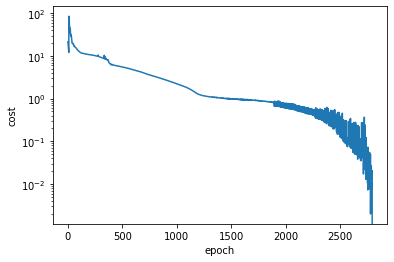

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

As we can observe from the above plot, the optimization was a bit of a bumpy ride towards the end. Situations like this can often be improved by decreasing the learning rate when approaching the minimum. For that we could have used one of the `torch.optim.lr_scheduler` classes or manually stop the optimization at some point, decrease the learning rate and resume from where we stopped.

To conclude the example we will run a crosscheck with the MADX simulation tool, in order to verify the results. We can serialize the current version of the lattice using the functions `create_script, sequence_script, track_script` from the `build` module. With `madx.utils.run_script` we can run the thus generated script and get back the tracking results in form of `pd.DataFrame` objects.

In [14]:
madx_script = create_script(
    sequence=lattice,
    track=track_script(particles, observe=['target', 'dump'], maxaper=[100]*6),  # Aperture is already on the elements.
    beam=dict(charge=6, mass=11.1779291448, energy=28.5779291448)
)
with open('result.madx', 'w') as fh:
    fh.write(madx_script)

results = run_script(madx_script, ['trackone', 'trackloss'], twiss=True, madx=os.path.expanduser('~/bin/madx'))
print('\nCrosscheck with MADX:')
print('\tFraction of particles lost: ', len(results['trackloss'])/particles.shape[1])
print('\tBeam spot size at target:   ', results['trackone'].loc['target', ['X', 'Y']].values.std(axis=0))
print('\tBeam spot size at beam dump:', results['trackone'].loc['dump', ['X', 'Y']].values.std(axis=0))


Crosscheck with MADX:
	Fraction of particles lost:  0.006
	Beam spot size at target:    [0.00051271 0.00050737]
	Beam spot size at beam dump: [0.01056864 0.00879908]


There's a small deviation in the results due to the fact that we used linear optics for the tracking while MADX uses non-linear update formulas.

Finally let's plot the quadrupole gradients along the beamline:

Text(0, 0.5, 'K1L [1/m]')

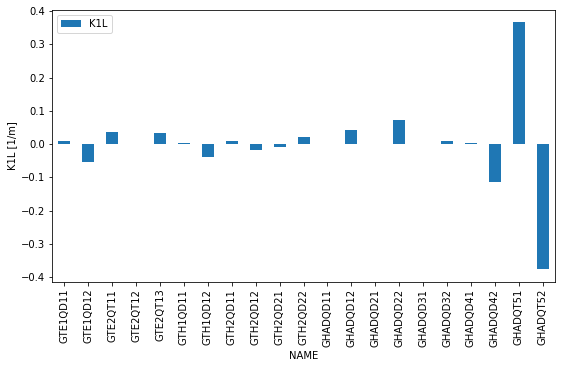

In [20]:
ax = results['twiss'][0].set_index('NAME').loc[[q.label.upper() for q in quadrupoles], ['K1L']].plot(kind='bar', figsize=(9, 5))
ax.set_ylabel('K1L [1/m]')